In [ ]:
!pip install contractions

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

In [5]:
!cp -r '$root/utils' .

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization, Dropout, Concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import tokenize, WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

# get data

In [7]:
raw_data = pickle.load(open(root+'raw_data_2103', 'rb'))
data = pickle.load(open(root+'preprocessed_data_2103', 'rb'))

In [8]:
input_dim = 10000

In [9]:
tokenizers, tokenized_data = tokenize(data, input_dim, quantile=0.9, verbose=True)

X_train: maxlen = 22
X_train_par: maxlen = 57


In [10]:
maxlen = tokenized_data['X_train'].shape[1]
maxlen_parent = tokenized_data['X_train_par'].shape[1]

# embedding matrices

In [11]:
vec_len = 100

In [12]:
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizers['comment'], root=root)

coverage: 0.9815


In [13]:
wordemb = WordEmbeddings()
emb_matrix_parent = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizers['parent'], root=root)

coverage: 0.9893


# no context

## CNN + biLSTM
up to date (31.03.2022)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=tf.keras.regularizers.L1L2(l1=5e-6, l2=5e-6)),
    Conv1D(32, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Bidirectional(LSTM(20, dropout=0.3)),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(tokenized_data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(tokenized_data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 59s 9ms/step - loss: 1.2330 - accuracy: 0.7015 - val_loss: 0.7140 - val_accuracy: 0.7146
Epoch 2/50
6002/6002 [==============================] - 56s 9ms/step - loss: 0.6591 - accuracy: 0.7211 - val_loss: 0.6285 - val_accuracy: 0.7243
Epoch 3/50
6002/6002 [==============================] - 55s 9ms/step - loss: 0.6164 - accuracy: 0.7271 - val_loss: 0.6114 - val_accuracy: 0.7236
Epoch 4/50
6002/6002 [==============================] - 56s 9ms/step - loss: 0.6002 - accuracy: 0.7317 - val_loss: 0.5999 - val_accuracy: 0.7288
Epoch 5/50
6002/6002 [==============================] - 56s 9ms/step - loss: 0.5912 - accuracy: 0.7353 - val_loss: 0.5948 - val_accuracy: 0.7314
Epoch 6/50
6002/6002 [==============================] - 56s 9ms/step - loss: 0.5855 - accuracy: 0.7385 - val_loss: 0.5912 - val_accuracy: 0.7329
Epoch 7/50
6002/6002 [==============================] - 56s 9ms/step - loss: 0.5821 - accuracy: 0.7410 - val_loss: 0.5913 - val_ac

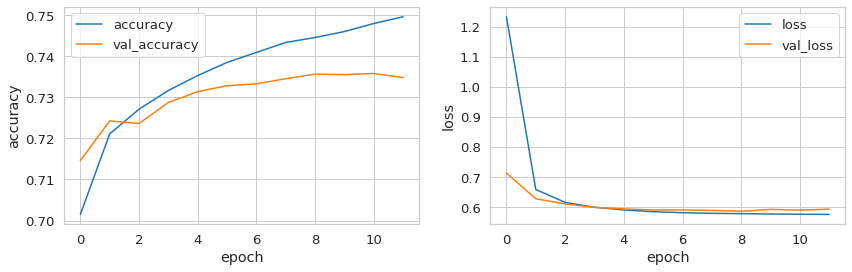

In [ ]:
plot_history(fit)

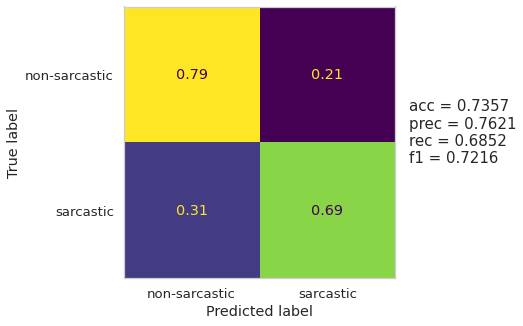

In [ ]:
evaluate(model, tokenized_data['X_val'], data['y_val'])

In [ ]:
show_errors(model, raw_data['X_val'].values, tokenized_data['X_val'], data['y_val'])

False negatives:
---------------------------
It works fine in my system though
I saw him in Lousiville, KY (I live in Lexington) and now I'm thinking about moving.
It's the Trop, no one was there to see it anyway.
Prophetic*
Shit and i just got this on VHS.

False positives:
---------------------------
Don't you dare argue with Correct the Record!
Fact that Giannis is 6'11 running a fast break and out running Lebron is sp00ky
But he's not a Korean or Chinese player tho?
Please don't get an 07 civic
But... it's already open.


In [ ]:
model.save(root+'models/cnn_bilstm')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_bilstm/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_bilstm/assets


## CNN + LSTM + DNN (Fracking Sarcasm using Neural Network)
up to date (31.03.2022)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=tf.keras.regularizers.L1L2(l1=5e-6, l2=5e-6)),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    LSTM(50, dropout=0.25, return_sequences=True),
    LSTM(50, dropout=0.25),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(tokenized_data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(tokenized_data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 154s 23ms/step - loss: 1.1458 - accuracy: 0.7042 - val_loss: 0.6942 - val_accuracy: 0.7211
Epoch 2/50
6002/6002 [==============================] - 138s 23ms/step - loss: 0.6477 - accuracy: 0.7253 - val_loss: 0.6212 - val_accuracy: 0.7261
Epoch 3/50
6002/6002 [==============================] - 138s 23ms/step - loss: 0.6065 - accuracy: 0.7312 - val_loss: 0.6010 - val_accuracy: 0.7324
Epoch 4/50
6002/6002 [==============================] - 138s 23ms/step - loss: 0.5921 - accuracy: 0.7362 - val_loss: 0.5909 - val_accuracy: 0.7328
Epoch 5/50
6002/6002 [==============================] - 138s 23ms/step - loss: 0.5841 - accuracy: 0.7393 - val_loss: 0.5867 - val_accuracy: 0.7360
Epoch 6/50
6002/6002 [==============================] - 140s 23ms/step - loss: 0.5797 - accuracy: 0.7432 - val_loss: 0.5851 - val_accuracy: 0.7384
Epoch 7/50
6002/6002 [==============================] - 138s 23ms/step - loss: 0.5762 - accuracy: 0.7456 - val_loss: 0

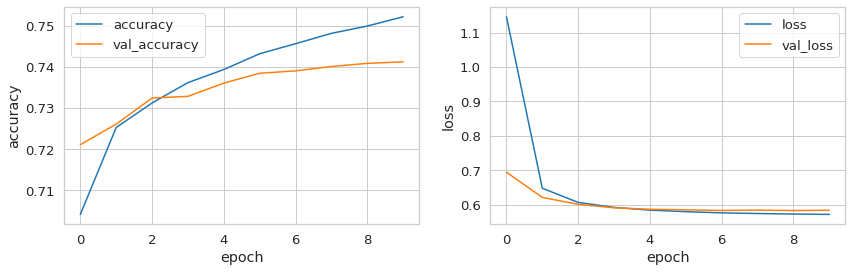

In [ ]:
plot_history(fit)

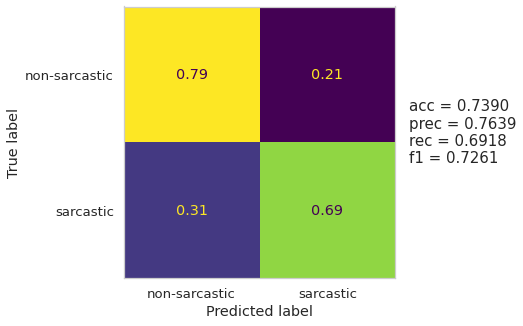

In [ ]:
evaluate(model, tokenized_data['X_val'], data['y_val'])

In [ ]:
show_errors(model, raw_data['X_val'].values, tokenized_data['X_val'], data['y_val'])

False negatives:
---------------------------
METAGAME OR DIE,
ITT hundreds of experts on the FBI I am humbled to be in the presence of so many people who know more about the agency than those who actually work there.
People still get haircuts?
Meh I'm more of a trump guy myself
The Asian American Female Employment Service (AAFES) wont hire you...its a damn dependa mafia over there.

False positives:
---------------------------
Which is why we stopped using freon about 20 years ago.
And so we've reached the core of this post
all racist groups just seem the same to me man sorry its hard to keep track
But I have to worry about reelection
Terrorists who succeed become patriots.


In [ ]:
model.save(root+'models/cnn_lstm_dnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_lstm_dnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_lstm_dnn/assets


# context
up to date (31.03.2022)

## 2 $\times$ CNN-LSTM-DNN 

In [ ]:
train_data = {'comment': tokenized_data['X_train'], 'parent': tokenized_data['X_train_par']}
val_data = {'comment': tokenized_data['X_val'], 'parent': tokenized_data['X_val_par']}

In [ ]:
def build_cnn_rnn(input_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(input_layer)
    x = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal')(x)
    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal')(x)
    x = LSTM(50, dropout=0.25, return_sequences=True)(x)
    x = LSTM(50, dropout=0.25)(x)

    return x

In [ ]:
comment_input =  keras.Input(shape=(None,), name='comment')
parent_input = keras.Input(shape=(None,), name='parent')

comment_rnn = build_cnn_rnn(comment_input, emb_matrix_comment, maxlen, reg=5e-6)
parent_rnn = build_cnn_rnn(parent_input, emb_matrix_parent, maxlen_parent, reg=5e-6)

x = Concatenate()([comment_rnn, parent_rnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 152s 22ms/step - loss: 1.4066 - accuracy: 0.7016 - val_loss: 0.6820 - val_accuracy: 0.7228
Epoch 2/50
6002/6002 [==============================] - 127s 21ms/step - loss: 0.6425 - accuracy: 0.7253 - val_loss: 0.6135 - val_accuracy: 0.7311
Epoch 3/50
6002/6002 [==============================] - 127s 21ms/step - loss: 0.6031 - accuracy: 0.7328 - val_loss: 0.5935 - val_accuracy: 0.7341
Epoch 4/50
6002/6002 [==============================] - 125s 21ms/step - loss: 0.5892 - accuracy: 0.7371 - val_loss: 0.5867 - val_accuracy: 0.7373
Epoch 5/50
6002/6002 [==============================] - 125s 21ms/step - loss: 0.5826 - accuracy: 0.7415 - val_loss: 0.5858 - val_accuracy: 0.7361
Epoch 6/50
6002/6002 [==============================] - 125s 21ms/step - loss: 0.5781 - accuracy: 0.7448 - val_loss: 0.5837 - val_accuracy: 0.7385
Epoch 7/50
6002/6002 [==============================] - 124s 21ms/step - loss: 0.5760 - accuracy: 0.7482 - val_loss: 0

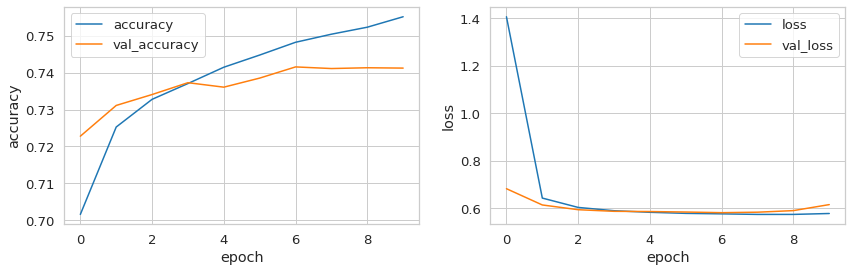

In [ ]:
plot_history(fit)

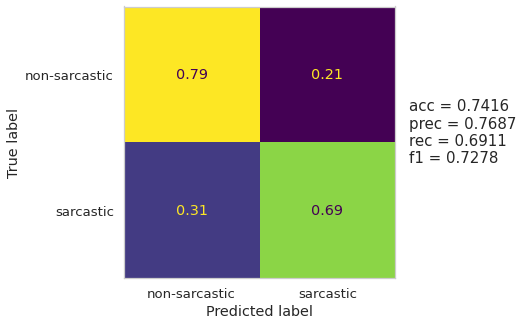

In [ ]:
evaluate(model, (tokenized_data['X_val'], tokenized_data['X_val_par']), data['y_val'])

In [ ]:
show_errors(model, raw_data['X_val'].values, (tokenized_data['X_val'], tokenized_data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: I won't downvote you, but the tone of this comment is pure cringe.
comment: RIDE ON BROTHER, LET THE POLITICAL REVOLUTION FLOW THROUGH YOUR M'ANE

parent: Ya I'm sure OP has never heard of that hidden gem
comment: Yeah, they're pretty unknown.

parent: Caterpillar Retail Sales Fall For Record 41 Consecutive Months
comment: And the "economic recovery" just keeps getting better, hell they may even raise interest rates.

parent: But dude, the Lakers FO is a joke, haven't you heard?
comment: Jim Bust lol

parent: Sorry! That was my brother we share an account
comment: Incredible how he and his brother write in the exact same style, even by length...


False positives:
---------------------------
parent: Upvoted for being so badass that you'd fap your way through the zomie apocalypse.
comment: Fap onto the zombie's amirite?

parent: Oh it will..
comment: Oh it has..

parent: Just to be clear: I upvoted you because I understand and can rel

In [ ]:
model.save(root+'models/context_cnn_lstm_dnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_cnn_lstm_dnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_cnn_lstm_dnn/assets


## comment: RNN, parent: CNN
up to date (01.04.2022)

In [14]:
train_data = {'comment': tokenized_data['X_train'], 'parent': tokenized_data['X_train_par']}
val_data = {'comment': tokenized_data['X_val'], 'parent': tokenized_data['X_val_par']}

In [15]:
def build_cnn(input_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(input_layer)

    x = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalMaxPooling1D()(x)

    return x

In [16]:
def build_rnn(input_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(input_layer)
    x = GRU(100, dropout=0.4)(x)

    return x

In [17]:
comment_input =  keras.Input(shape=(None,), name='comment')
parent_input = keras.Input(shape=(None,), name='parent')

comment_rnn = build_rnn(comment_input, emb_matrix_comment, maxlen, reg=3e-6)
parent_rnn = build_cnn(parent_input, emb_matrix_parent, maxlen_parent, reg=5e-6)

x = Concatenate()([comment_rnn, parent_rnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 505s 81ms/step - loss: 2.0010 - accuracy: 0.6982 - val_loss: 0.7201 - val_accuracy: 0.7257
Epoch 2/50
6002/6002 [==============================] - 477s 80ms/step - loss: 0.6512 - accuracy: 0.7254 - val_loss: 0.6116 - val_accuracy: 0.7323
Epoch 3/50
6002/6002 [==============================] - 474s 79ms/step - loss: 0.6068 - accuracy: 0.7329 - val_loss: 0.5893 - val_accuracy: 0.7397
Epoch 4/50
6002/6002 [==============================] - 473s 79ms/step - loss: 0.5931 - accuracy: 0.7386 - val_loss: 0.5815 - val_accuracy: 0.7428
Epoch 5/50
6002/6002 [==============================] - 467s 78ms/step - loss: 0.5867 - accuracy: 0.7425 - val_loss: 0.5785 - val_accuracy: 0.7452
Epoch 6/50
6002/6002 [==============================] - 474s 79ms/step - loss: 0.5829 - accuracy: 0.7465 - val_loss: 0.5802 - val_accuracy: 0.7457
Epoch 7/50
6002/6002 [==============================] - 471s 78ms/step - loss: 0.5802 - accuracy: 0.7491 - val_loss: 0

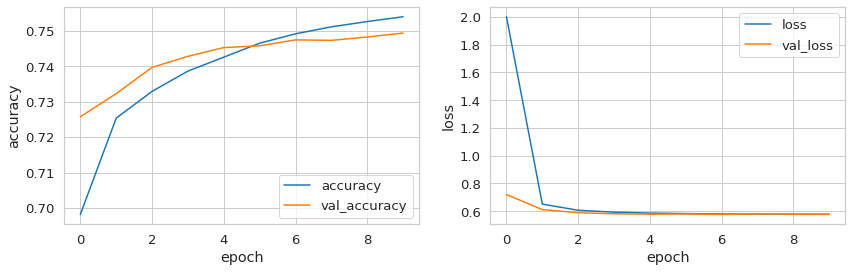

In [18]:
plot_history(fit)

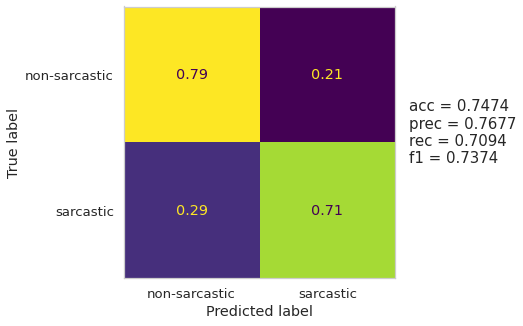

In [19]:
evaluate(model, (tokenized_data['X_val'], tokenized_data['X_val_par']), data['y_val'])

In [20]:
show_errors(model, raw_data['X_val'].values, (tokenized_data['X_val'], tokenized_data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: Pretty sure Matt and Burnie weren't in college in 2008, buddy.
comment: That's Burnie in the trailer though.

parent: Arizona's New Governor: We Have No Money for Public Education, But Let's Fund This Private Prison.
comment: Well if the kids had given him more lobby dollars he might have done something for them but those cheapskates ignored him.

parent: Quicksell your binder
comment: Probably the best option on the thread

parent: Anyone here work in the Daily Mail offices? Go stir this one up.
comment: Do you think anyone working for the Daily Mail would dare show their face around here?

parent: OP made the Raiders pay for it too
comment: WITH THERE LIVES!


False positives:
---------------------------
parent: Your friends really like to ND.
comment: Plot twist, OP is the one nd'ing and he feels compelled to confess without outing himself

parent: New to the NFL, how to learn about teams and decide on a team? I'm new to the NFL. 

In [21]:
model.save(root+'models/context_rnn_cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_rnn_cnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_rnn_cnn/assets
